# Assignment 6 Math Foundations Machine Learning
## David Alvear 187594

In [14]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import seaborn as sns
# from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import multivariate_normal
from torch.utils.data import Dataset, random_split, DataLoader

## 2. Comparing three classifiers.

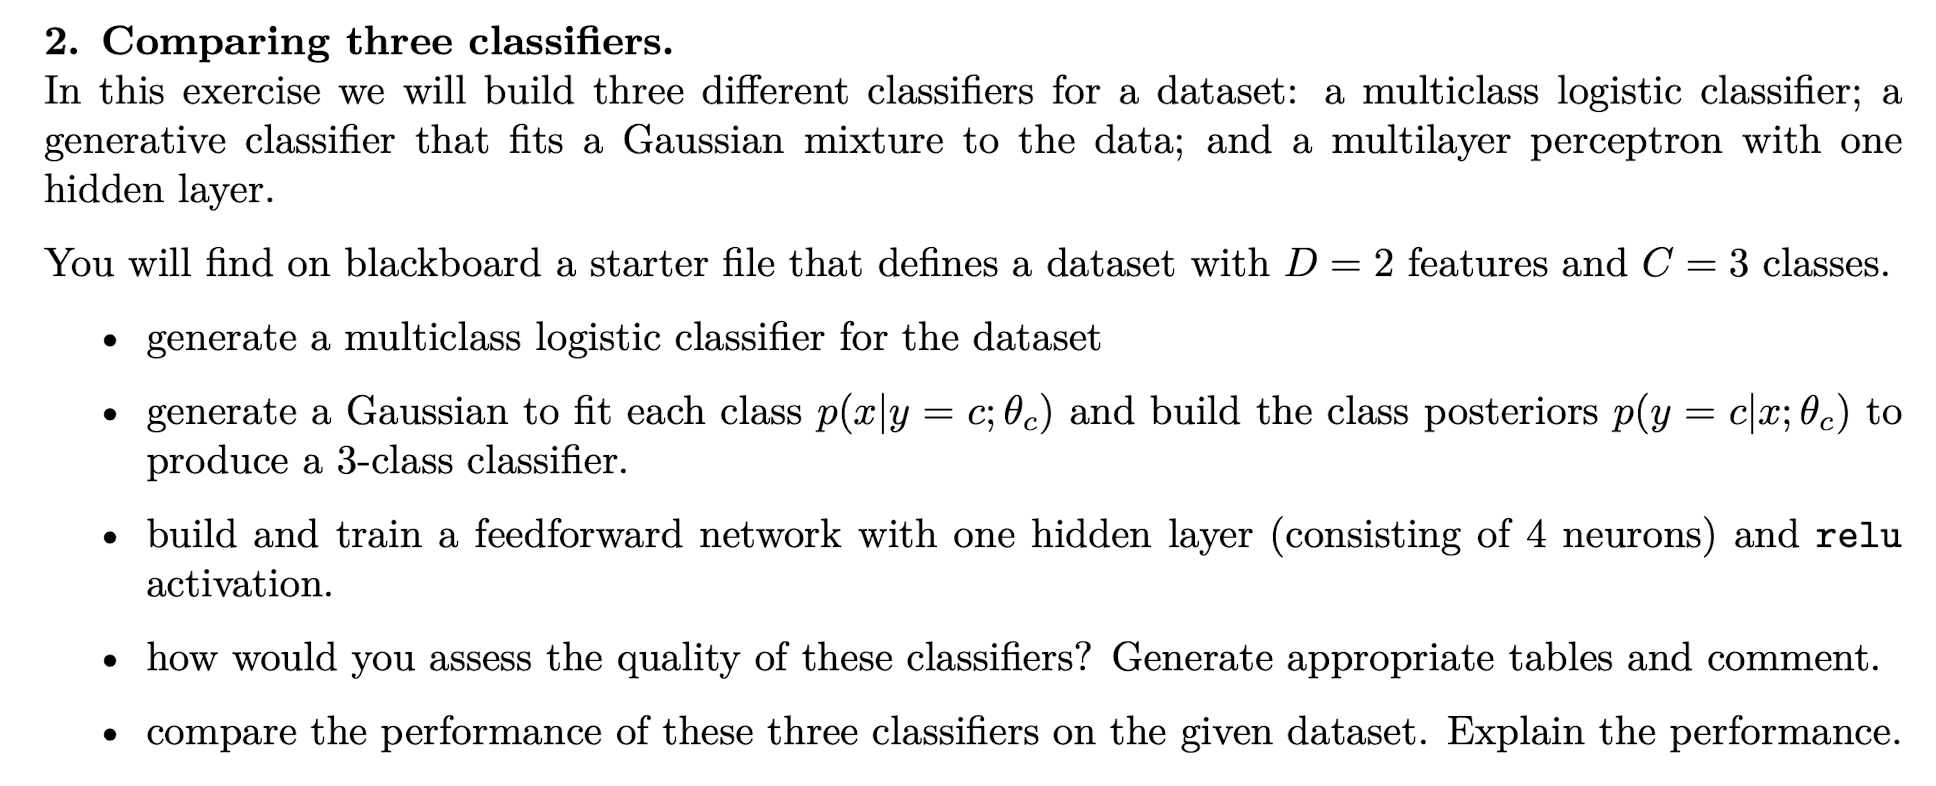

In [43]:
##########################################
####### Create Dataset  ##########
##########################################
class ClassificationDataset(Dataset):
    def __init__(self, X:torch.tensor, Y:torch.tensor):
        self.X = X
        self.Y = Y
        self.feature_size = self.X.size(1)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

##########################################
###### Split and create Dataset ##########
##########################################
def divide_dataset(dataset, test_prop=0.2):
    train_size = int(len(dataset) * (1 - test_prop))
    test_size = int(len(dataset) * test_prop)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset
    
##########################################
############## Plot semilog ##############
##########################################
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 6))
    plt.semilogy(train_loss, label='Training Loss')
    plt.semilogy(test_loss, label='Testing Loss')
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    yticks = np.linspace(ymin, ymax, num=10)  # Create 10 equally spaced ticks
    plt.yticks(yticks)  # Set custom y-ticks
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_confusion_matrix(test_labels, test_predicted_labels, labels=[1,0]):
    print("\nCONFUSSION MATRIX\n")
    conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def visualize_classification_report(test_labels, test_predicted_labels, labels=[1,0]):
    # Generate the test classification report
    print("\nCLASSIFICATION REPORT\n")
    report = classification_report(test_labels, test_predicted_labels, target_names=labels)
    print(report)

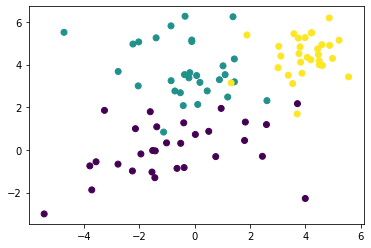

In [47]:
seed = 215*2
C = 3    # 3 classes
Nc = 30  # 30 data points per class
N = Nc * C   

mean = [[0, 0], [0, 4], [4, 4]]
cov1 = np.array([[4, 1], [1, 2]])
cov2 = np.array([[2, 0], [0, 1]])
cov3 = np.eye(2)
cov = [cov1, cov2, cov3]

# generate data by sampling from 3 gaussians
rng = np.random.default_rng(seed)
X0 = rng.multivariate_normal(mean[0], cov[0], Nc)
X1 = rng.multivariate_normal(mean[1], cov[1], Nc)
X2 = rng.multivariate_normal(mean[2], cov[2], Nc)

X = np.concatenate((X0, X1, X2))      # store sample points
y = np.concatenate((0*np.ones(Nc), 1*np.ones(Nc), 2*np.ones(Nc)))  # class labels

# plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [48]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_one_hot = pd.get_dummies(y).values
y_tensor = torch.tensor(y_one_hot, dtype=torch.float32)
mc_dataset = ClassificationDataset(X_tensor, y_tensor)
train_dataset, test_dataset = divide_dataset(mc_dataset)

### Multiclass Logistic Classifier

In [49]:
##########################################
##### Logistic Regression Training #######
##########################################
class BinaryLogisticRegression:
    def __init__(self, model:torch.nn.Module, train_dataset:Dataset, test_dataset:Dataset, criterion='manual'):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.criterion = criterion if criterion == 'manual' else torch.nn.BCELoss()
        self.model = model

    def loss(self, pred_tensor, labels_tensor):
        if self.criterion == 'manual':
            loss = -torch.mean(labels_tensor.squeeze() * torch.log(pred_tensor.squeeze()) + (1 - labels_tensor.squeeze()) * torch.log(1 - pred_tensor.squeeze()))
        else:
            loss = self.criterion(pred_tensor.squeeze(), labels_tensor.squeeze())
        return loss

    def test_model(self):
        # get the data
        test_data, labels = self.test_dataset[:]
        # predict 
        with torch.no_grad():
            pred_labels = self.model(test_data)
        test_loss = self.loss(pred_labels, labels)
        return test_loss.item()

    def SGD(self, learning_rate=0.001, batch_size=10, num_epochs=100):
        opt = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        data_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True) # randomize and get the batches

        self.train_loss = []
        self.test_loss = []
        for epoch in range(num_epochs):
            total_loss = 0
            for data_batch, label_batch in data_loader:

                # Reset gradients
                self.model.zero_grad()
            
                # Forward pass
                prob_predicted = self.model(data_batch)
        
                # calculate loss
                loss = self.loss(prob_predicted, label_batch) # compute the loss for the batch
                total_loss += loss.item()
        
                # Backward pass
                loss.backward()
    
                # step SGD opt
                opt.step()

            # test the model 
            loss_test_epoch = self.test_model()
            self.train_loss.append(total_loss / len(data_loader))
            self.test_loss.append(loss_test_epoch)
            # print epoch
            print(f"Epoch: {epoch}, Training Loss Avg: {total_loss / len(data_loader):.4f}, Test Loss: {loss_test_epoch:.4f}")

##########################################
##### Logistic Regression Training #######
##########################################
class MulticlassLogisticRegressionTrainer(BinaryLogisticRegression):
    def __init__(self, model:torch.nn.Module, train_dataset:Dataset, test_dataset:Dataset, criterion='manual', regularizer='l1', lambda_reg=0.001):
        super(MulticlassLogisticRegressionTrainer, self).__init__(model, train_dataset, test_dataset, criterion='manual')
        self.criterion = criterion if criterion == 'manual' else torch.nn.CrossEntropyLoss()
        self.regularizer = regularizer
        self.lambda_reg = lambda_reg
        
    # Redefine the loss for the multiclass application
    def loss(self, pred_tensor, labels_tensor):
        if self.criterion == 'manual':
            loss = -torch.mean(torch.sum(labels_tensor * torch.log(torch.softmax(pred_tensor, dim=1)), dim=1))
        else:
            loss = self.criterion(pred_tensor, labels_tensor)

        if self.regularizer == 'l1':
            loss += self.lambda_reg * sum(torch.norm(p, 1) for p in model.parameters())

        return loss

##########################################
## Multiclass Logistic Regression Model ##
##########################################
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [50]:
# Create the model
feature_size = mc_dataset.feature_size
mc_model = MulticlassLogisticRegression(feature_size, C)
print(mc_model.linear.weight)

Parameter containing:
tensor([[0.5412, 0.0885],
        [0.6583, 0.2764],
        [0.5619, 0.5604]], requires_grad=True)


In [51]:
# Create the trainer
MLR_trainer = MulticlassLogisticRegressionTrainer(mc_model, train_dataset, test_dataset, criterion='manual', regularizer=None) # crossentropyloss
# Train the model
MLR_trainer.SGD(num_epochs=2000)

Epoch: 0, Training Loss Avg: 1.1236, Test Loss: 1.0130
Epoch: 1, Training Loss Avg: 1.0846, Test Loss: 1.0033
Epoch: 2, Training Loss Avg: 1.1147, Test Loss: 0.9934
Epoch: 3, Training Loss Avg: 1.1366, Test Loss: 0.9838
Epoch: 4, Training Loss Avg: 1.0675, Test Loss: 0.9747
Epoch: 5, Training Loss Avg: 1.0764, Test Loss: 0.9659
Epoch: 6, Training Loss Avg: 0.9801, Test Loss: 0.9580
Epoch: 7, Training Loss Avg: 0.9878, Test Loss: 0.9500
Epoch: 8, Training Loss Avg: 1.0425, Test Loss: 0.9423
Epoch: 9, Training Loss Avg: 1.0333, Test Loss: 0.9322
Epoch: 10, Training Loss Avg: 0.9525, Test Loss: 0.9249
Epoch: 11, Training Loss Avg: 0.9705, Test Loss: 0.9178
Epoch: 12, Training Loss Avg: 1.0332, Test Loss: 0.9099
Epoch: 13, Training Loss Avg: 0.9723, Test Loss: 0.9030
Epoch: 14, Training Loss Avg: 0.9610, Test Loss: 0.8963
Epoch: 15, Training Loss Avg: 1.0132, Test Loss: 0.8888
Epoch: 16, Training Loss Avg: 1.0080, Test Loss: 0.8834
Epoch: 17, Training Loss Avg: 0.9460, Test Loss: 0.8777
Ep

### Gaussian Mixture Model Classifier

In [78]:
x_train, y_train = train_dataset[:]
x_test, y_test = test_dataset[:]
# numpy format
x_train = x_train.numpy()
x_test = x_test.numpy()
y_train = np.argmax(y_train.numpy(), axis=1)
y_test = np.argmax(y_test.numpy(), axis=1)

In [90]:
class GaussianMixtureModel:
    def __init__(self, train_X, train_y):
        self.X = train_X
        self.y = train_y
        self.models_params = {}

    def fit_data(self):
        class_labels = np.unique(self.y)
        for label in class_labels:
            # Compute the mean and std for the class
            indices = np.where(self.y==label)
            data = self.X[indices] # Data for class 'label'
            mean = np.mean(data, axis=0)
            cov = np.cov(data, rowvar=False)
            self.models_params[label] = {'mean': mean, 'cov': cov, 'prior': len(indices)/len(self.X)}

    def predict(self, x_test):
        posteriors = np.zeros((x_test.shape[0], len(np.unique(self.y))))
        for model_class in self.models_params.keys():
            mean = self.models_params[model_class]['mean']
            cov = self.models_params[model_class]['cov']
            prior = self.models_params[model_class]['prior']
            # Calculate likelihood P(x|y=c, theta_c)
            likelihood = multivariate_normal.pdf(x_test, mean, cov)
            # Calculate posterior P(y=c|x)
            posterior = likelihood * prior
            posteriors[:,model_class] = posterior
        # calculate the predictions
        predictions = np.argmax(posteriors, axis=1)
        return predictions            

In [95]:
model_GMM = GaussianMixtureModel(x_train, y_train)
model_GMM.fit_data()
y_pred_GMM = model_GMM.predict(x_test)
y_test_GMM = y_test

### Feedforward Neural Network

In [101]:
##########################################
## Multiclass  Model ##
##########################################
class ModelClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelClassifier, self).__init__()
        # self.linear = nn.Linear(input_dim, output_dim)
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 4), # Four neurons
            nn.ReLU(inplace=True),
            nn.Linear(4, output_dim),
        )
        
    def forward(self, x):
        return self.layer(x)        

In [150]:
criterion = nn.CrossEntropyLoss()
model_FFN = ModelClassifier(X.shape[1],C) # Features:2 Classes:3
optimizer = torch.optim.Adam(model_FFN.parameters(), lr=0.01)

# dataloader
batch_size=10
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # randomize and get the batches

num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(data_loader):
        # Forward pass
        scores = model_FFN(data)
        loss = criterion(scores, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 1.5995
Epoch [2/100], Loss: 0.6703
Epoch [3/100], Loss: 0.3495
Epoch [4/100], Loss: 0.5729
Epoch [5/100], Loss: 0.8586
Epoch [6/100], Loss: 0.9795
Epoch [7/100], Loss: 0.2465
Epoch [8/100], Loss: 1.3621
Epoch [9/100], Loss: 1.4197
Epoch [10/100], Loss: 0.1180
Epoch [11/100], Loss: 0.5317
Epoch [12/100], Loss: 0.0395
Epoch [13/100], Loss: 0.3354
Epoch [14/100], Loss: 0.2206
Epoch [15/100], Loss: 0.0307
Epoch [16/100], Loss: 0.0447
Epoch [17/100], Loss: 0.1502
Epoch [18/100], Loss: 0.3464
Epoch [19/100], Loss: 0.3998
Epoch [20/100], Loss: 0.5549
Epoch [21/100], Loss: 0.8516
Epoch [22/100], Loss: 0.4637
Epoch [23/100], Loss: 0.5415
Epoch [24/100], Loss: 0.1252
Epoch [25/100], Loss: 0.4744
Epoch [26/100], Loss: 0.2167
Epoch [27/100], Loss: 0.0685
Epoch [28/100], Loss: 0.5590
Epoch [29/100], Loss: 0.2429
Epoch [30/100], Loss: 0.0309
Epoch [31/100], Loss: 0.2010
Epoch [32/100], Loss: 0.0084
Epoch [33/100], Loss: 0.2384
Epoch [34/100], Loss: 0.1370
Epoch [35/100], Loss: 0

In [151]:
test_data, test_labels = test_dataset[:]
pred_y_FFN = np.argmax(model_FFN(test_data).softmax(dim=1).detach().numpy(), axis=1)
test_y_FFN = np.argmax(test_labels.numpy(), axis=1)

### Performance Comparison

#### Multiclass Logistic Regression


CONFUSSION MATRIX



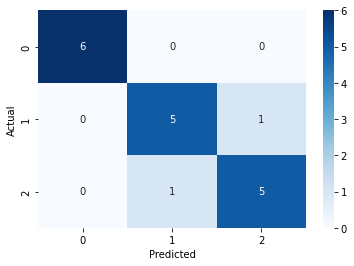


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      0.83      0.83         6
           2       0.83      0.83      0.83         6

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



In [46]:
# Visualize confusion matrix to obtain more information
test_data, test_labels = test_dataset[:]
test_labels_indices = torch.argmax(test_labels, dim=1)
test_logits = mc_model(test_data).squeeze()
test_labels_predicted = torch.softmax(test_logits, dim=1).squeeze().detach()
test_labels_predicted_indices = torch.argmax(test_labels_predicted, dim=1)

visualize_confusion_matrix(test_labels_indices, test_labels_predicted_indices, labels=["0","1","2"])
visualize_classification_report(test_labels_indices, test_labels_predicted_indices, labels=["0","1","2"])

*Comments*
- Trained using SGD for 2000 epochs and Achieved an accuracy of 89%. 
- There are some misclassifications between "1" and "2" classes, but still the model has a good performance in unseen data.

#### Gaussian Mixture Model Classifier


CONFUSSION MATRIX



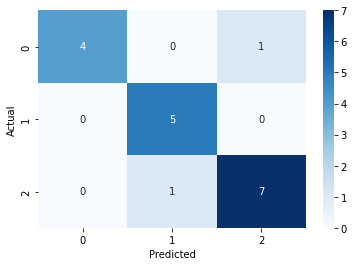


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       0.88      0.88      0.88         8

    accuracy                           0.89        18
   macro avg       0.90      0.89      0.89        18
weighted avg       0.90      0.89      0.89        18



In [96]:
visualize_confusion_matrix(y_test_GMM, y_pred_GMM, labels=["0","1","2"])
visualize_classification_report(y_test_GMM, y_pred_GMM, labels=["0","1","2"])

*Comments*
- This Gaussian Mixture Model achieved the same accuracy that the Multi Class logistic regression of 89%
- The model has a good performance classifying unseen data.
- Still exist a missclassification but in general the model has a good performance.

#### Feedforward Neural Network


CONFUSSION MATRIX



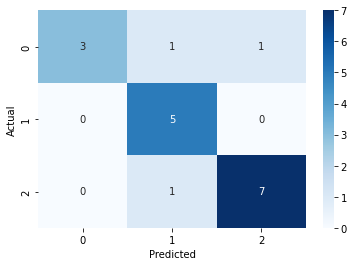


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5
           2       0.88      0.88      0.88         8

    accuracy                           0.83        18
   macro avg       0.86      0.83      0.82        18
weighted avg       0.87      0.83      0.83        18



In [152]:
visualize_confusion_matrix(test_y_FFN, pred_y_FFN, labels=["0","1","2"])
visualize_classification_report(test_y_FFN, pred_y_FFN, labels=["0","1","2"])

*Comments*
- The FFN is sensitive to the hyperparameters. Chossing them can give a good or bad performance, in this case having a low learning rate increased the variability of the loss while reducing the performance of the model.
- A difference of the previous models the FFN has an accuracy of 83%. However, this could be increased tunning the parameters of the model, increasing the training epochs and having a proper testing dataset to evaluate the network and conclude the performance.

## 5. MLP for MNIST data
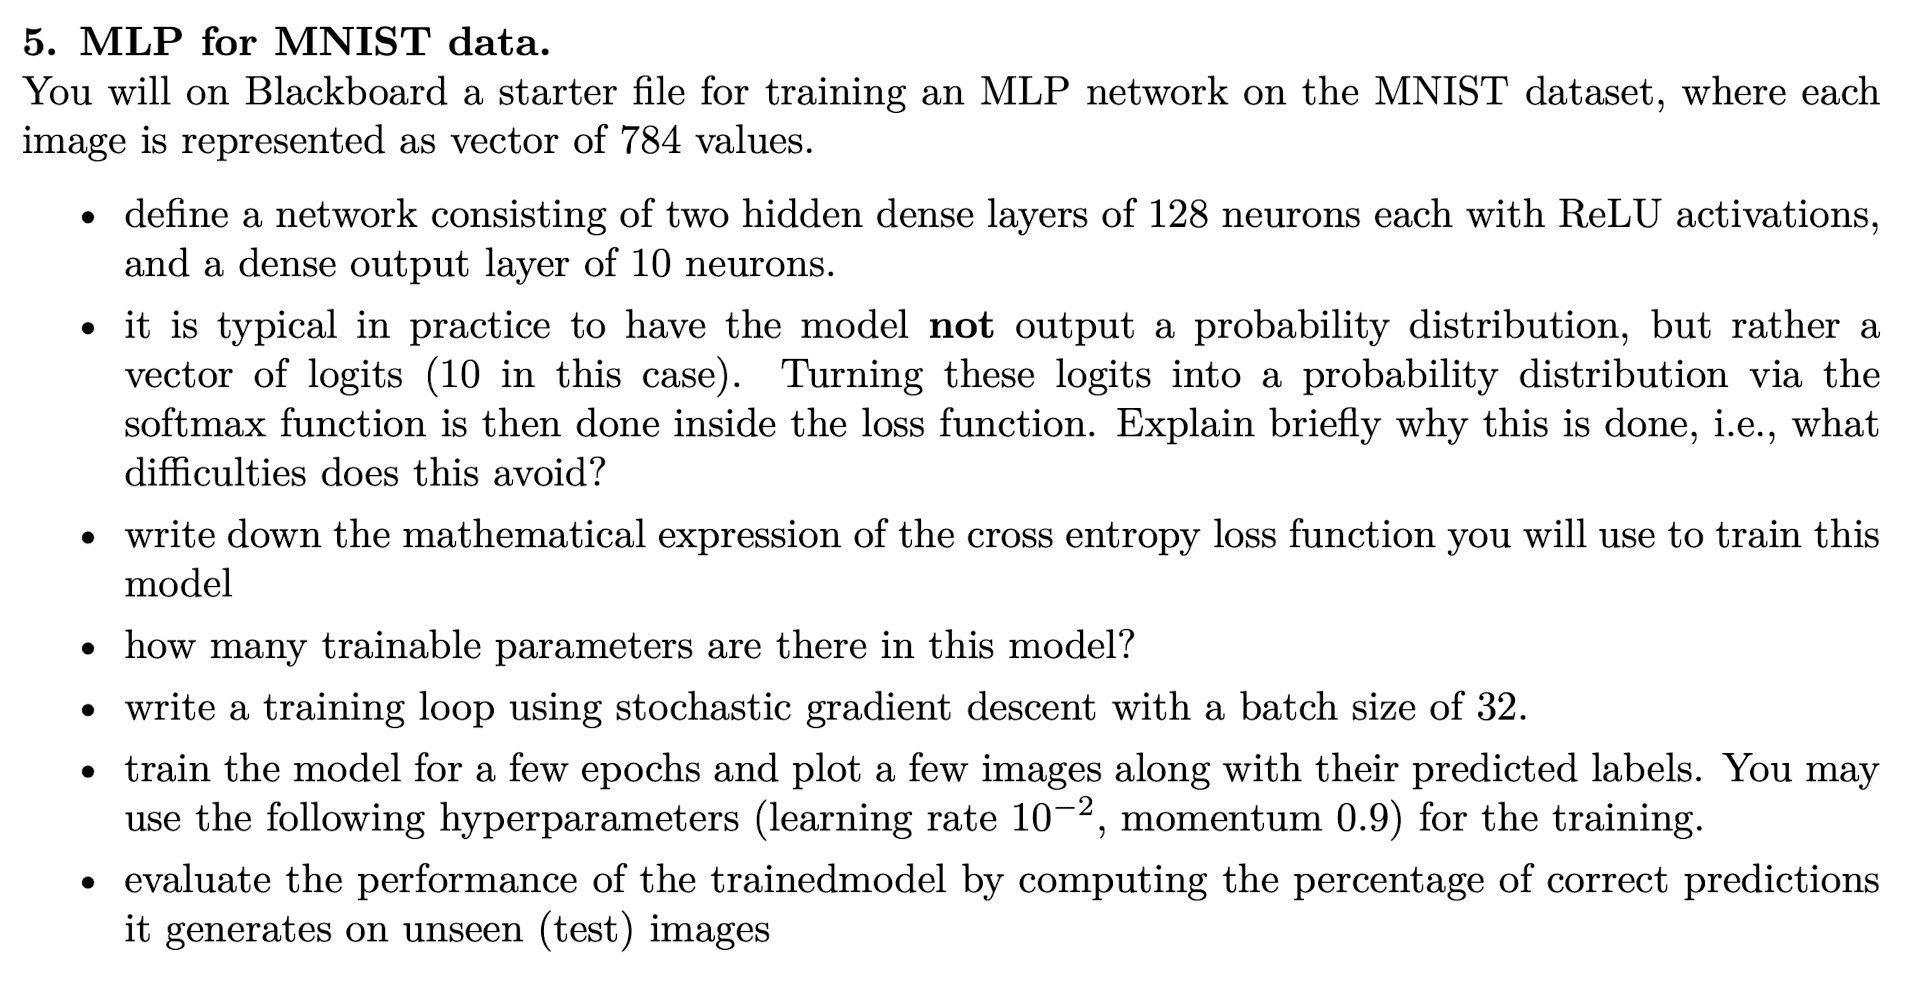

In [52]:
# read MNIST training data
df = pd.read_csv('../data/mnist_train.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()                # labels of images

# divide the data into batches (we loop through the batches in training)
batch_size = 32
batches = int(np.ceil(X.shape[0]/batch_size))
X_batched = np.array_split(X, batches)
y_batched = np.array_split(y, batches)

In [53]:
class MnistClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MnistClassifierModel, self).__init__()
        # self.linear = nn.Linear(input_dim, output_dim)
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 128), # Four neurons
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim),
        )
        
    def forward(self, x):
        return self.layer(x)    

In [54]:
# define model
mnist_model = MnistClassifierModel(X.shape[1], 10)

In [55]:
# parameters
summary(mnist_model, input_size=(X.shape[1],), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 128]         100,480
              ReLU-2                  [32, 128]               0
            Linear-3                  [32, 128]          16,512
              ReLU-4                  [32, 128]               0
            Linear-5                   [32, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.13
Params size (MB): 0.45
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


**Why the output of the model is logits and not probability distributions? What difficulties avoid?**

- I multi-class classification is common to output logits instead of probability distributions. The loss function 'cross-entropy' combines the softmax operation with the negative log likelihood, this produce more numerical stability rather than using the softmax function. The softmax involves exponentials that can result in very large or very small numbers.
- The logits are more suitable for gradient optimization. Softmax function can squash gradients in regions that the network is confident.
- The use of logits in the output of the model can avoid the following difficulties: underflow(because of the exp in the softmax), overflow(because of the exp in the softmax), vanishing gradients, probabilities can saturate.

**CrossEntropyLoss**

**C**: number of classes
**N**: number of data points

$CrossEntropyLoss = \frac{1}{N} \sum_{i=1}^N H(y_n, \hat{y}_n) = \frac{1}{N} \sum_{i=1}^N \sum_{i=1}^C y_{nc}log(P_c)$

$P_c = -exp(z_c - lse(z)) = - exp(z_c - log\sum_{i=1}^Cexp(z_c))$

**Learnable Parameters**

Total params: 118,282

Trainable params: 118,282

Non-trainable params: 0

In [56]:
def plot_images(images, labels, predictions=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        title = f"True: {labels[i]}"
        if predictions is not None:
            title += f", Pred: {predictions[i]}"
        ax.set_title(title)
        ax.axis('off')
    plt.show()

Epoch [1/15], Loss: 0.1027


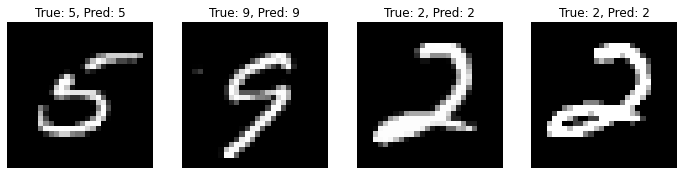

Epoch [2/15], Loss: 0.0715


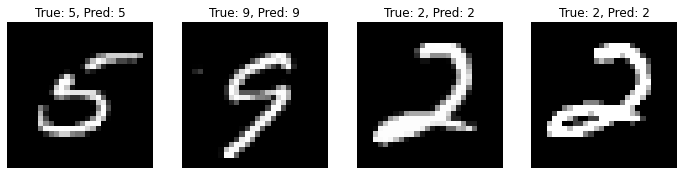

Epoch [3/15], Loss: 0.0536


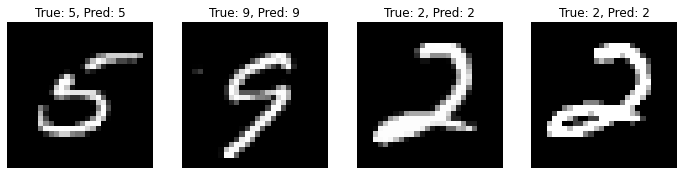

Epoch [4/15], Loss: 0.0431


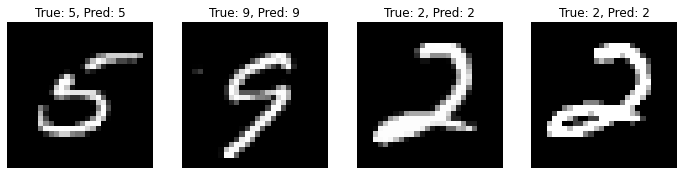

Epoch [5/15], Loss: 0.0253


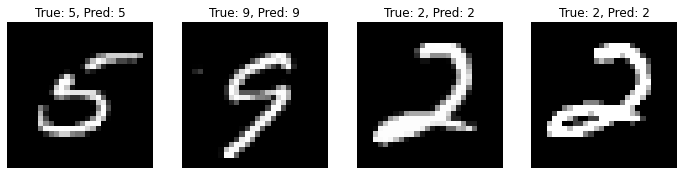

Epoch [6/15], Loss: 0.0213


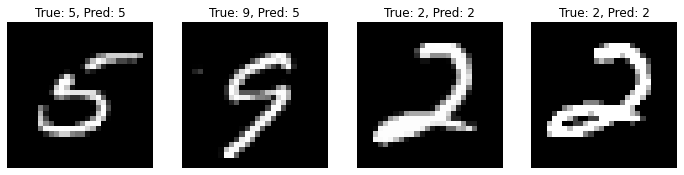

Epoch [7/15], Loss: 0.0135


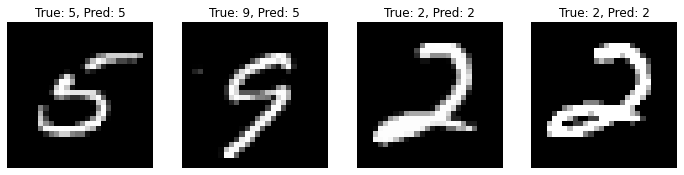

Epoch [8/15], Loss: 0.0047


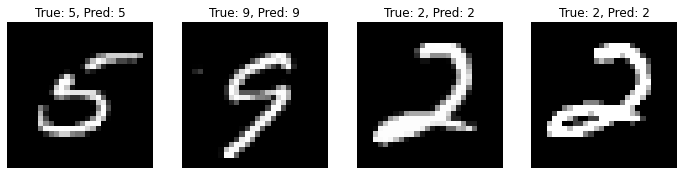

Epoch [9/15], Loss: 0.0029


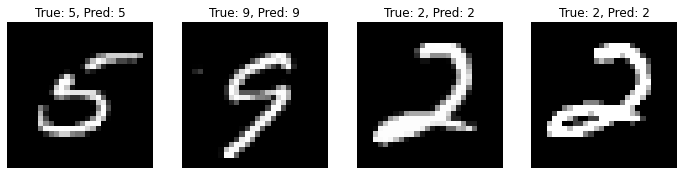

Epoch [10/15], Loss: 0.0032


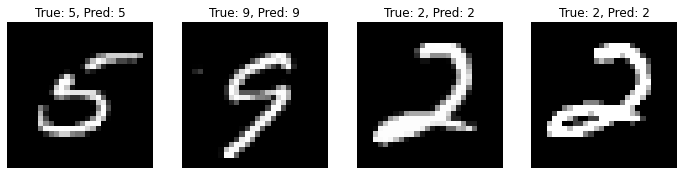

Epoch [11/15], Loss: 0.0024


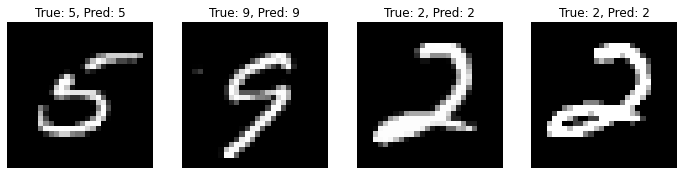

Epoch [12/15], Loss: 0.0012


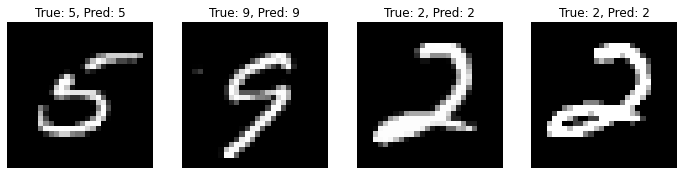

Epoch [13/15], Loss: 0.0015


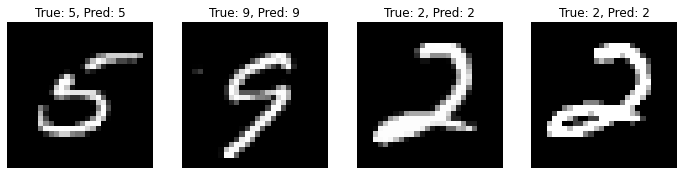

Epoch [14/15], Loss: 0.0005


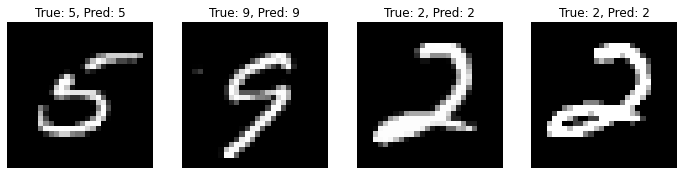

Epoch [15/15], Loss: 0.0010


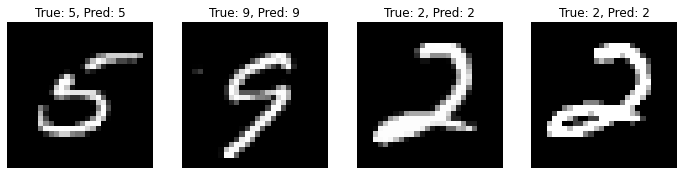

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 15
# leave the last batch for testing 
for epoch in range(num_epochs):
    for batch_idx in range(batches-1):
        # Get the batched data and targets
        data = torch.tensor(X_batched[batch_idx], dtype=torch.float32)
        targets = torch.tensor(y_batched[batch_idx], dtype=torch.long)
        
        # Forward pass
        logits = mnist_model(data)
        loss = criterion(logits, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    with torch.no_grad():
        sample_data = torch.tensor(X_batched[-1][:4], dtype=torch.float32)
        sample_targets = y_batched[-1][:4]
        sample_logits = mnist_model(sample_data)
        sample_predictions = torch.argmax(sample_logits, dim=1).numpy()
        plot_images(sample_data.numpy(), sample_targets, sample_predictions)


CONFUSSION MATRIX



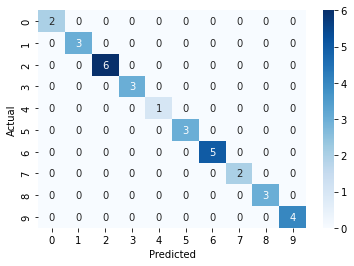


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [45]:
# USE THE LAST BATCH NOT USED IN TRAINING FOR TESTING
with torch.no_grad():
    data_test = torch.tensor(X_batched[-1], dtype=torch.float32)
    y_pred_mnist = np.argmax(mnist_model(data_test).softmax(dim=1).detach().numpy(), axis=1)
    y_test_mnist = torch.tensor(y_batched[-1], dtype=torch.long)

visualize_confusion_matrix(y_test_mnist, y_pred_mnist, labels=["0","1","2","3","4","5","6","7","8","9"])
visualize_classification_report(y_test_mnist, y_pred_mnist, labels=["0","1","2","3","4","5","6","7","8","9"])